In [1]:
import numpy as np
import networkx as nx

In [2]:
filename = './USA-road-d.NY.co/USA-road-d.NY.co' # txt文件和当前脚本在同一目录下，所以不用写具体路径
Efield = []
x_list = []
y_list = []
with open(filename, 'r') as file_to_read:
    count = 0
    while True:
        item = []
        lines = file_to_read.readline() # 整行读取数据
        if not lines:
            break
        v, id, x_loc, y_loc = [i for i in lines.split()] # 将整行数据分割处理，如果分割符是空格，括号里就不用传入参数，如果是逗号， 则传入‘，'字符。
        item.append(int(id))  # 添加新读取的数据
        item.append(int(x_loc))
        item.append(int(y_loc))
        Efield.append(item)
        x_list.append(int(x_loc))
        y_list.append(int(y_loc))
        count += 1
"""         if count % 1000 == 0:
            print("count:",count)
            print("item:",item) """
city_show_num = 4000
x_list = np.array(x_list)[0:city_show_num]
y_list = np.array(y_list)[0:city_show_num]

city_co = np.array(Efield)
print(city_co)
print(x_list)

[[        1 -73530767  41085396]
 [        2 -73530538  41086098]
 [        3 -73519366  41048796]
 ...
 [   264344 -73820681  40994683]
 [   264345 -73714376  41004205]
 [   264346 -73917690  41291980]]
[-73530767 -73530538 -73519366 ... -73515866 -73512266 -73511366]


## 读取图连通关系

In [3]:
filename = './USA-road-d.NY.gr/USA-road-d.NY.gr' # txt文件和当前脚本在同一目录下，所以不用写具体路径
Efield = []
with open(filename, 'r') as file_to_read:
    count = 0
    while True:
        item = []
        lines = file_to_read.readline() # 整行读取数据
        if not lines:
            break
        a, v_i, v_j, dis_ij = [i for i in lines.split()] # 将整行数据分割处理，如果分割符是空格，括号里就不用传入参数，如果是逗号， 则传入‘，'字符。
        item.append(int(v_i))  # 添加新读取的数据
        item.append(int(v_j))
        item.append(int(dis_ij))
        Efield.append(item)
        count += 1
"""         if count % 1000 == 0:
            print("count:",count)
            print("item:",item)  """

dis_table = np.array(Efield)
print(len(dis_table))
print(dis_table)

733846
[[     1      2    803]
 [     2      1    803]
 [     3      4    158]
 ...
 [263813 263466    106]
 [261228 259707    389]
 [259707 261228    389]]


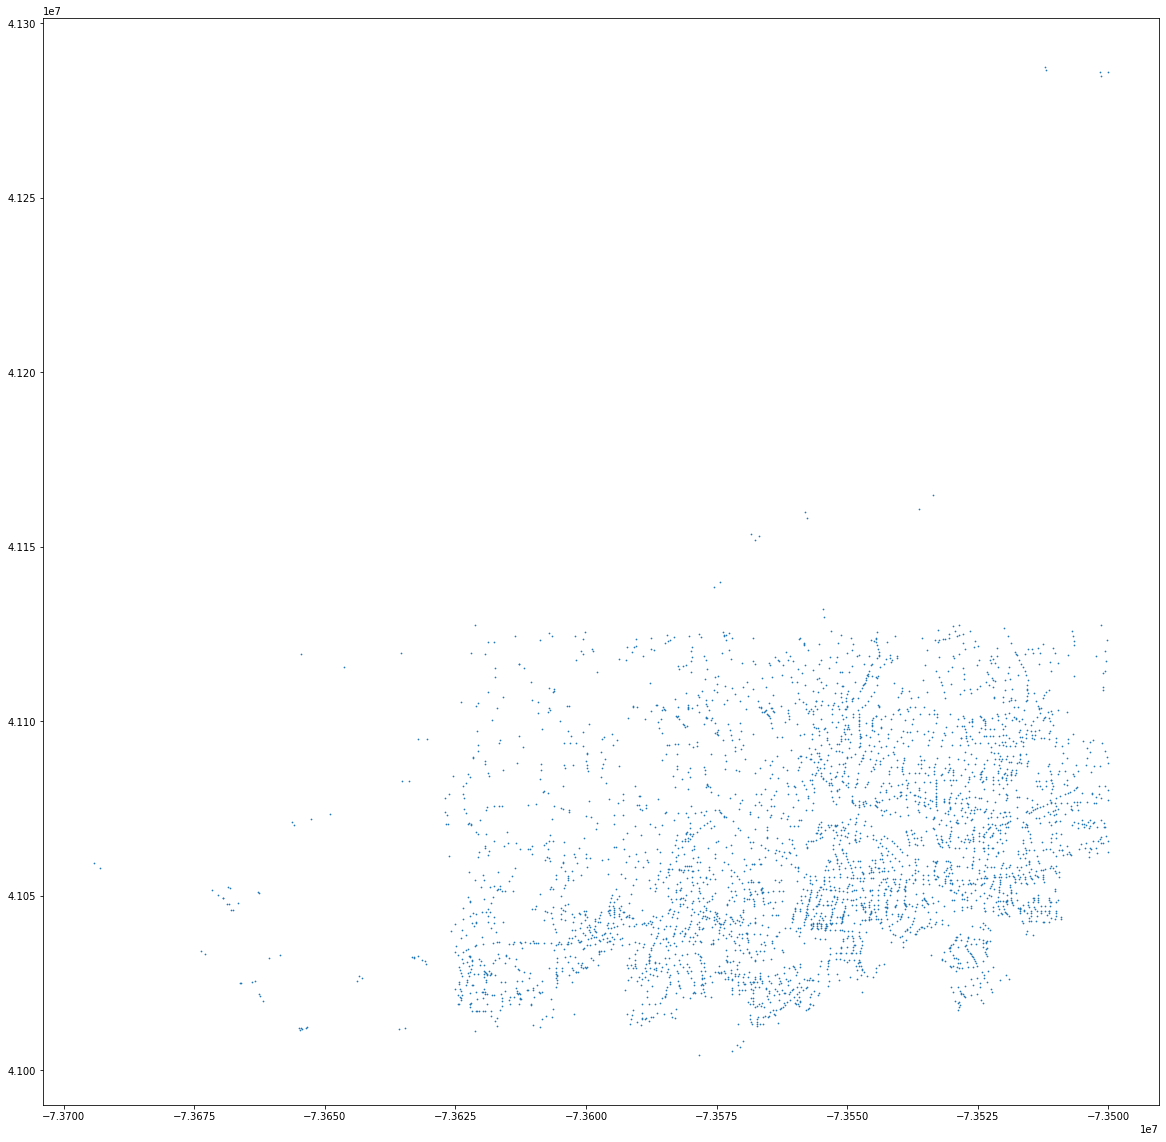

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))

""" for edge in dis_table[:1000]:
    x_1 = city_co[edge[0],1]
    x_2 = city_co[edge[1],1]
    X = [x_1, x_2]
    y_1 = city_co[edge[0],2]
    y_2 = city_co[edge[1],2]
    Y = [y_1, y_2]
    plt.plot(X, Y, color = 'r', linewidth = 0.1) """
# plt.savefig("map.png")
plt.scatter(x_list,y_list,s=0.5)
plt.show()

In [7]:
# -*- coding: utf-8 -*-
import random
import copy
import time
import numpy as np
import sys
import math
import tkinter #//GUI模块
import threading
import pandas as pd
from functools import reduce

# 参数
'''
ALPHA:信息启发因子，值越大，则蚂蚁选择之前走过的路径可能性就越大
      ，值越小，则蚁群搜索范围就会减少，容易陷入局部最优
BETA:Beta值越大，蚁群越就容易选择局部较短路径，这时算法收敛速度会
     加快，但是随机性不高，容易得到局部的相对最优
'''
(ALPHA, BETA, RHO, Q) = (1.0,2.0,0.005 ,5000)
# 城市数，蚁群
(city_num, ant_num) = (40, 30)
distance_nx_graph = nx.DiGraph()
pheromone_nx_graph = nx.DiGraph()




In [8]:
from classAnt import *

def update_pheromone_gragh(ants,target):

    # 获取每只蚂蚁在其路径上留下的信息素
    for ant in ants:
        #如果这条路无法到达，则不应该更新信息素
        if ant.path[-1] != target:
            continue
        for i in range(1,len(ant.path)):
            start, end = ant.path[i-1], ant.path[i]
            # 在路径上的每两个相邻城市间留下信息素，与路径总距离反比
            #temp_pheromone[start][end] += Q / ant.total_distance
            # temp_vertex = pheromone_adja_graph.vertList[start]
            temp_pheromone = pheromone_nx_graph.get_edge_data(start, end)['weight'] * (1-RHO)
            # 更新所有城市之间的信息素，旧信息素衰减加上新迭代信息素
            temp_pheromone += Q / ant.total_distance
            pheromone_nx_graph.add_weighted_edges_from([(start,end,temp_pheromone)])

def initial_map(city_num):
        # 初始化邻接表
    distance_nx_graph.clear()
    pheromone_nx_graph.clear()
    initial_pheromone = 1
    for item in dis_table:
        if item[0] <= city_num and item[1] <= city_num:
            distance_nx_graph.add_weighted_edges_from([(item[0],item[1],item[2])])
            pheromone_nx_graph.add_weighted_edges_from([(item[0],item[1],initial_pheromone)])

def initial_ants(start, target):
    global ants
    ants = [Ant(ID,target,start, city_num, ALPHA, BETA, RHO, Q) for ID in range(ant_num)]  # 初始蚁群

def search_path(start,target,city_co):
    
    
    # best_ant = Ant(-1,target,start)                          # 初始最优解
    #best_ant.total_distance = np.inf           # 初始最好的蚂蚁
    best_distance = np.inf
    
    iter = 1

    while True:
        # 遍历每一只蚂蚁
        tic = time.time()
        count = 0
        for ant in ants:
            # 搜索一条路径
            print("ant:", count)
            ant.search_path(distance_nx_graph, pheromone_nx_graph, city_co)
            # 与当前最优蚂蚁比较
            #print(ant.path)
            #print(ant.total_distance)
            count += 1
            if ant.total_distance < best_distance and ant.path[-1] == target:
                # 更新最优解
                #best_ant = copy.deepcopy(ant)
                best_path = ant.path
                best_distance = ant.total_distance
                print('found a path!')

        # 更新信息素
        update_pheromone_gragh(ants,target)
        if best_distance < np.inf:
            toc = time.time()
            gap = toc-tic
            path_str = '%d' % best_path[0]
            # 给定策略然后进行选择
            for i in range(len(best_path) - 1):
                """ if strategy_graph[best_path[i]][best_path[i+1]] == 1:
                    path_str = path_str + '--freeway--'
                elif strategy_graph[best_path[i]][best_path[i+1]] == 2:
                    path_str = path_str + '--road--' """
                path_str = path_str + '------' + '%d' % best_path[i+1]
            # 给定策略的概率，按概率进行选择?这样似乎是不太合理的。因为只有策略确定了之后，才有相应的评价体系，先后顺序不能乱
            """ for i in range(len(best_path) - 1):
                if prob_graph[best_path[i]][best_path[i+1]] >= 0:
                    # 二项分布随机数
                    the_choice = np.random.binomial(1,prob_graph[best_path[i]][best_path[i+1]],size = 1)
                    print(prob_graph[best_path[i]][best_path[i+1]])
                    if the_choice == 1:
                        path_str = path_str + '--freeway--'
                    elif the_choice == 0:
                        path_str = path_str + '--road--'
                    path_str = path_str + '%d' % best_path[i+1] """
            print (u"迭代次数：",iter,u"最佳路径总距离：",int(best_distance),"路径为：",path_str,"搜索时长：",gap)
        else:
            print(u"迭代次数：",iter,u"无法到达！")
        iter += 1
        if iter > 5:
            break


显示起终点在地图中的相对位置

In [11]:
# 设置起点和终点
start = 2000
target = 145210

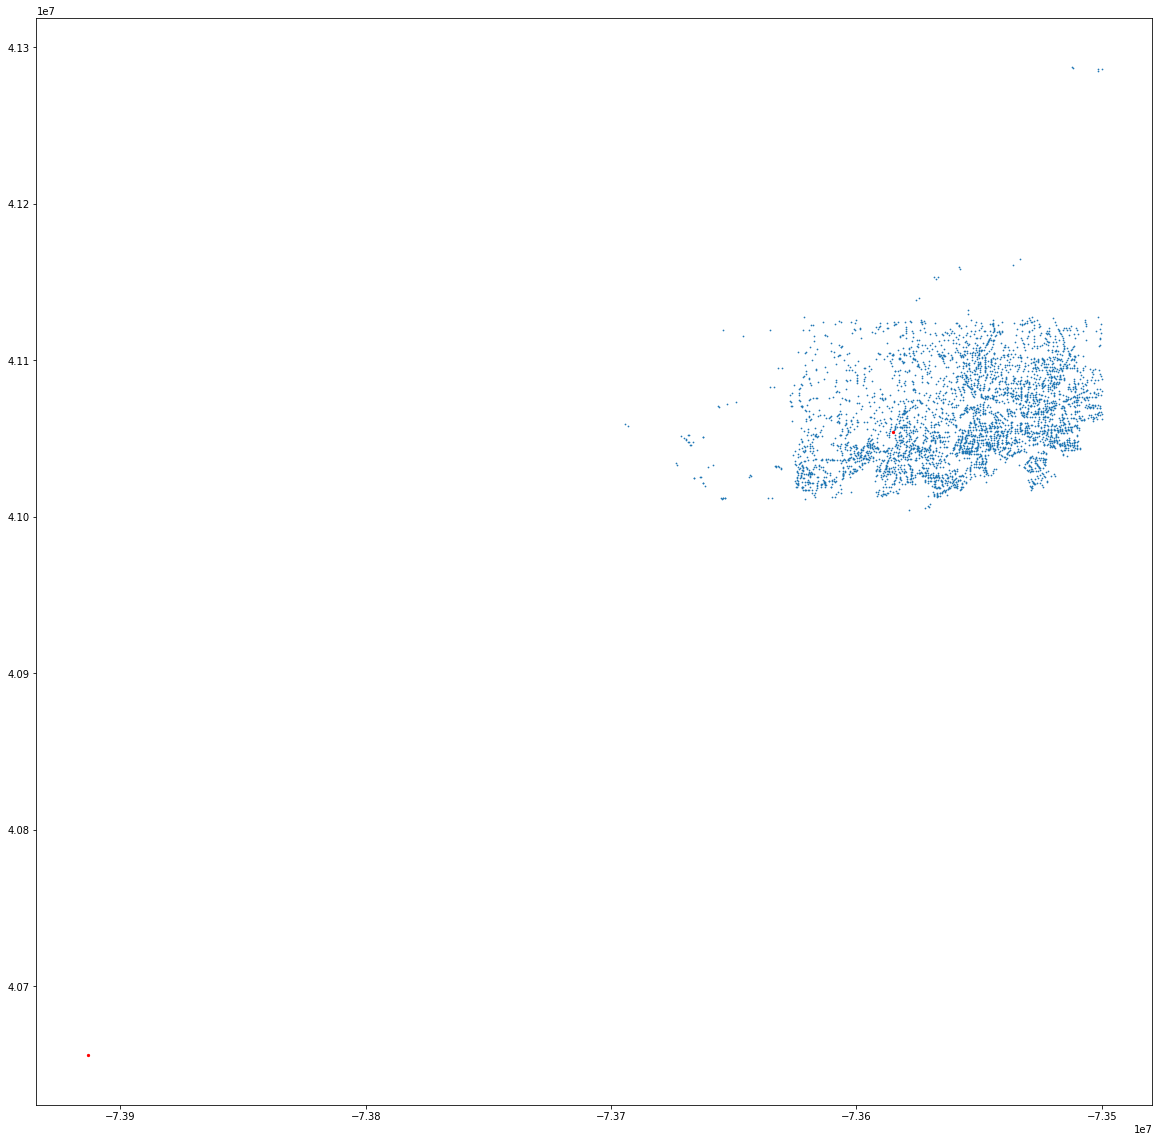

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.scatter(x_list,y_list,s=0.5)
""" for edge in dis_table[:1000]:
    x_1 = city_co[edge[0],1]
    x_2 = city_co[edge[1],1]
    X = [x_1, x_2]
    y_1 = city_co[edge[0],2]
    y_2 = city_co[edge[1],2]
    Y = [y_1, y_2]
    plt.plot(X, Y, color = 'r', linewidth = 0.1) """
# plt.savefig("map.png")
x_start = city_co[start,1]
x_target = city_co[target,1]
X = [x_start, x_target]
y_start = city_co[start,2]
y_target = city_co[target,2]
Y = [y_start, y_target]
plt.scatter(X,Y,c = 'r', s=5)
plt.show()

开始测试搜索

In [9]:
initial_map(city_num)

In [14]:
print(distance_nx_graph.get_edge_data(297, 294)['weight'])
print(distance_nx_graph.succ[297])

2773
{294: {'weight': 2773}, 343: {'weight': 2512}}


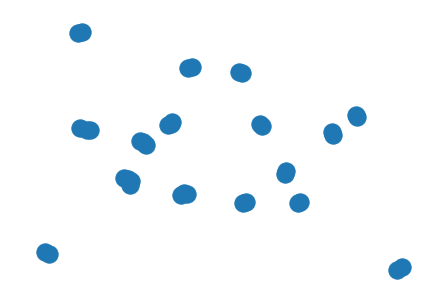

In [10]:
nx.draw(distance_nx_graph)

In [15]:
initial_ants(start,target)

In [16]:
search_path(start, target, city_co)

ant: 0


KeyboardInterrupt: 

In [ ]:
start, target = 296,301
weight = abs(city_co[start,1] - city_co[target, 1]) + abs(city_co[start,2] - city_co[target, 2])
print(weight)